<a href="https://colab.research.google.com/github/InbalBolshinsky/multi-modal-mutation-detector/blob/main/notebooks/LungCancer_ClinVar_DataPrep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloading the VCF file from ClinVar and extracting it.

In [1]:
import os

# File URL
url = "ftp://ftp.ncbi.nlm.nih.gov/pub/clinvar/vcf_GRCh38/clinvar.vcf.gz"

# Check if the file exists
if not os.path.exists("clinvar.vcf.gz"):
    # Download the file
    !wget -O clinvar.vcf.gz {url}
    print("File downloaded.")
else:
    print("File already exists, skipping download.")

# Decompress the file
!gunzip -f clinvar.vcf.gz


--2024-12-28 19:15:46--  ftp://ftp.ncbi.nlm.nih.gov/pub/clinvar/vcf_GRCh38/clinvar.vcf.gz
           => ‘clinvar.vcf.gz’
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.12, 130.14.250.13, 130.14.250.7, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.12|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/clinvar/vcf_GRCh38 ... done.
==> SIZE clinvar.vcf.gz ... 105077076
==> PASV ... done.    ==> RETR clinvar.vcf.gz ... done.
Length: 105077076 (100M) (unauthoritative)

clinvar.vcf.gz      100%[===================>] 100.21M  42.9MB/s    in 2.3s    

2024-12-28 19:15:50 (42.9 MB/s) - ‘clinvar.vcf.gz’ saved [105077076]

File downloaded.


Viewing clinvar.vcf head:

In [3]:
!grep "CLNDN=" clinvar.vcf | head

1	66926	3385321	AG	A	.	.	ALLELEID=3544463;CLNDISDB=Human_Phenotype_Ontology:HP:0000547,MONDO:MONDO:0019200,MeSH:D012174,MedGen:C0035334,OMIM:268000,OMIM:PS268000,Orphanet:791;CLNDN=Retinitis_pigmentosa;CLNHGVS=NC_000001.11:g.66927del;CLNREVSTAT=criteria_provided,_single_submitter;CLNSIG=Uncertain_significance;CLNVC=Deletion;CLNVCSO=SO:0000159;GENEINFO=OR4F5:79501;MC=SO:0001627|intron_variant;ORIGIN=0
1	69134	2205837	A	G	.	.	ALLELEID=2193183;CLNDISDB=MedGen:CN169374;CLNDN=not_specified;CLNHGVS=NC_000001.11:g.69134A>G;CLNREVSTAT=criteria_provided,_single_submitter;CLNSIG=Likely_benign;CLNVC=single_nucleotide_variant;CLNVCSO=SO:0001483;GENEINFO=OR4F5:79501;MC=SO:0001583|missense_variant;ORIGIN=1
1	69314	3205580	T	G	.	.	ALLELEID=3374047;CLNDISDB=MedGen:CN169374;CLNDN=not_specified;CLNHGVS=NC_000001.11:g.69314T>G;CLNREVSTAT=criteria_provided,_single_submitter;CLNSIG=Uncertain_significance;CLNVC=single_nucleotide_variant;CLNVCSO=SO:0001483;GENEINFO=OR4F5:79501;MC=SO:0001583|missense_variant;

Install Required Libraries and Import Modules

In [4]:
# Install necessary libraries
!pip install pysam

# Import required modules
import pysam
import pandas as pd
import os


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 MB 57.4 MB/s eta 0:00:00


Load the VCF File into a DataFrame

In [ ]:
vcf_file = "clinvar.vcf"
columns = ["CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO"]

# Use Pandas to read the VCF file
df = pd.read_csv(vcf_file, sep="\t", comment='#', names=columns, dtype={'CHROM': str}, low_memory=False)

Parse the INFO Field

In [ ]:
# Parse INFO column into separate key-value pairs
def parse_info(info):
    parsed = {}
    for entry in info.split(";"):
        if "=" in entry:
            key, value = entry.split("=", 1)
            parsed[key] = value
    return parsed

# Apply parse_info to the INFO column
df["INFO"] = df["INFO"].apply(parse_info)

# Expand parsed INFO into separate columns
info_df = pd.DataFrame(df["INFO"].tolist(), index=df.index)
df = pd.concat([df.drop(columns=["INFO"]), info_df], axis=1)

In [ ]:
info_df.head(2).T

,0,1
ALLELEID,3544463,2193183
CLNDISDB,"Human_Phenotype_Ontology:HP:0000547,MONDO:MOND...",MedGen:CN169374
CLNDN,Retinitis_pigmentosa,not_specified
CLNHGVS,NC_000001.11:g.66927del,NC_000001.11:g.69134A>G
CLNREVSTAT,"criteria_provided,_single_submitter","criteria_provided,_single_submitter"
CLNSIG,Uncertain_significance,Likely_benign
CLNVC,Deletion,single_nucleotide_variant
CLNVCSO,SO:0000159,SO:0001483
GENEINFO,OR4F5:79501,OR4F5:79501
MC,SO:0001627|intron_variant,SO:0001583|missense_variant


Check for Missing Columns and Pre-Filter Data

In [ ]:
# Check for missing columns and handle them
if "GENEINFO" not in df.columns:
    print("Warning: GENEINFO column is missing. Please verify the VCF file format.")
    df["GENEINFO"] = None

if "CLNSIG" not in df.columns:
    print("Warning: CLNSIG column is missing. Please verify the VCF file format.")
    df["CLNSIG"] = None

# Pre-filter rows with non-null GENEINFO
df = df[df["GENEINFO"].notna()]

In [ ]:
df.head(2).T

,0,1
CHROM,1,1
POS,66926,69134
ID,3385321,2205837
REF,AG,A
ALT,A,G
QUAL,.,.
FILTER,.,.
ALLELEID,3544463,2193183
CLNDISDB,"Human_Phenotype_Ontology:HP:0000547,MONDO:MOND...",MedGen:CN169374
CLNDN,Retinitis_pigmentosa,not_specified


Initializing dictionary to store filtered by gene dataFrames and viewing the count for each gene

In [ ]:
# Define relevant genes and classifications
genes_of_interest = ["EGFR", "KRAS", "ALK"]
classifications = {
    "Pathogenic/Likely_Pathogenic": ["Pathogenic", "Likely_pathogenic"],
    "Benign/Likely_Benign": ["Benign", "Likely_benign"],
    "VUS": ["Uncertain_significance"]
}

# Initialize dictionary to store filtered DataFrames
filtered_dfs = {}

# Process data for each gene and classification
for gene in genes_of_interest:
    print(f"----------Processing gene: {gene}----------")
    for classification_name, classification_values in classifications.items():
        # Filter data for specific gene and classification
        filtered_df = df[
            (df["GENEINFO"].str.contains(gene, na=False)) &
            (df["CLNSIG"].isin(classification_values))
        ]
        count = len(filtered_df)
        print(f"{gene}_{classification_name.replace(' ', '_')}: {count}")
        # Store the filtered DataFrame in the dictionary
        key = f"{gene}_{classification_name.replace(' ', '_')}"
        filtered_dfs[key] = filtered_df

----------Processing gene: EGFR----------
EGFR_Pathogenic/Likely_Pathogenic: 90
EGFR_Benign/Likely_Benign: 1290
EGFR_VUS: 1410
----------Processing gene: KRAS----------
KRAS_Pathogenic/Likely_Pathogenic: 58
KRAS_Benign/Likely_Benign: 146
KRAS_VUS: 198
----------Processing gene: ALK----------
ALK_Pathogenic/Likely_Pathogenic: 125
ALK_Benign/Likely_Benign: 2460
ALK_VUS: 3433


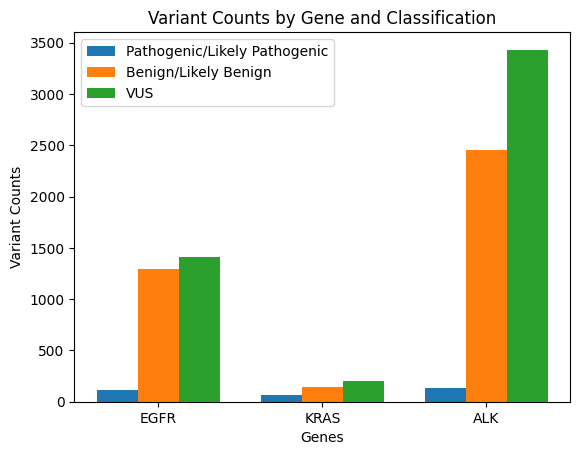

In [ ]:
import matplotlib.pyplot as plt

# Data for visualization
genes = ["EGFR", "KRAS", "ALK"]
pathogenic_counts = [119, 62, 131]
benign_counts = [1292, 146, 2458]
vus_counts = [1409, 198, 3432]

# Plotting
bar_width = 0.25
x = range(len(genes))

plt.bar(x, pathogenic_counts, width=bar_width, label="Pathogenic/Likely Pathogenic")
plt.bar([p + bar_width for p in x], benign_counts, width=bar_width, label="Benign/Likely Benign")
plt.bar([p + 2 * bar_width for p in x], vus_counts, width=bar_width, label="VUS")

plt.xticks([p + bar_width for p in x], genes)
plt.xlabel("Genes")
plt.ylabel("Variant Counts")
plt.title("Variant Counts by Gene and Classification")
plt.legend()
plt.show()

Inspecting DataFrames:

In [ ]:
# Ensure consistent column names across all DataFrames
columns = list(filtered_dfs.values())[0].columns

# Dictionary to store null status
null_status = {}

# Check each column for nulls across all DataFrames
for column in columns:
    is_null_in_all = all(df[column].isnull().all() for df in filtered_dfs.values())
    null_status[column] = is_null_in_all

# Identify columns to drop
columns_to_drop = [column for column, status in null_status.items() if status]

# Drop these columns from each DataFrame
for key, df in filtered_dfs.items():
    filtered_dfs[key] = df.drop(columns=columns_to_drop)

print(f"Dropped columns: {columns_to_drop}")


Dropped columns: ['CLNSIGCONF', 'CLNDISDBINCL', 'CLNDNINCL', 'CLNSIGINCL', 'SCI', 'SCIREVSTAT', 'DBVARID', 'SCIDISDB', 'SCIDN', 'ONCDISDBINCL', 'ONCDNINCL', 'ONCINCL']


Check which columns are null accross all dfs:

In [ ]:
# Iterate through the columns of one DataFrame (assuming all have the same structure)
columns = list(filtered_dfs.values())[0].columns

# Dictionary to store results for each column
null_status = {}

# Check each column across all DataFrames
for column in columns:
    is_null_in_all = all(df[column].isnull().all() for df in filtered_dfs.values())
    null_status[column] = is_null_in_all

# Print results
for column, status in null_status.items():
    if status:
        print(f"The column '{column}' is NULL in all DataFrames")


The column 'CLNSIGCONF' is NULL in all DataFrames
The column 'CLNDISDBINCL' is NULL in all DataFrames
The column 'CLNDNINCL' is NULL in all DataFrames
The column 'CLNSIGINCL' is NULL in all DataFrames
The column 'SCI' is NULL in all DataFrames
The column 'SCIREVSTAT' is NULL in all DataFrames
The column 'DBVARID' is NULL in all DataFrames
The column 'SCIDISDB' is NULL in all DataFrames
The column 'SCIDN' is NULL in all DataFrames
The column 'ONCDISDBINCL' is NULL in all DataFrames
The column 'ONCDNINCL' is NULL in all DataFrames
The column 'ONCINCL' is NULL in all DataFrames


drop them

In [ ]:
# Find columns that are null in all DataFrames
columns_to_drop = [
    column for column, status in null_status.items() if status
]

# Drop these columns from each DataFrame
for key, df in filtered_dfs.items():
    filtered_dfs[key] = df.drop(columns=columns_to_drop)

print(f"Dropped columns: {columns_to_drop}")


Dropped columns: ['CLNSIGCONF', 'CLNDISDBINCL', 'CLNDNINCL', 'CLNSIGINCL', 'SCI', 'SCIREVSTAT', 'DBVARID', 'SCIDISDB', 'SCIDN', 'ONCDISDBINCL', 'ONCDNINCL', 'ONCINCL']


Visualization for Null Count and Percentage

============== EGFR_Pathogenic/Likely_Pathogenic Summary ==============

Total rows: 90
Total columns: 27



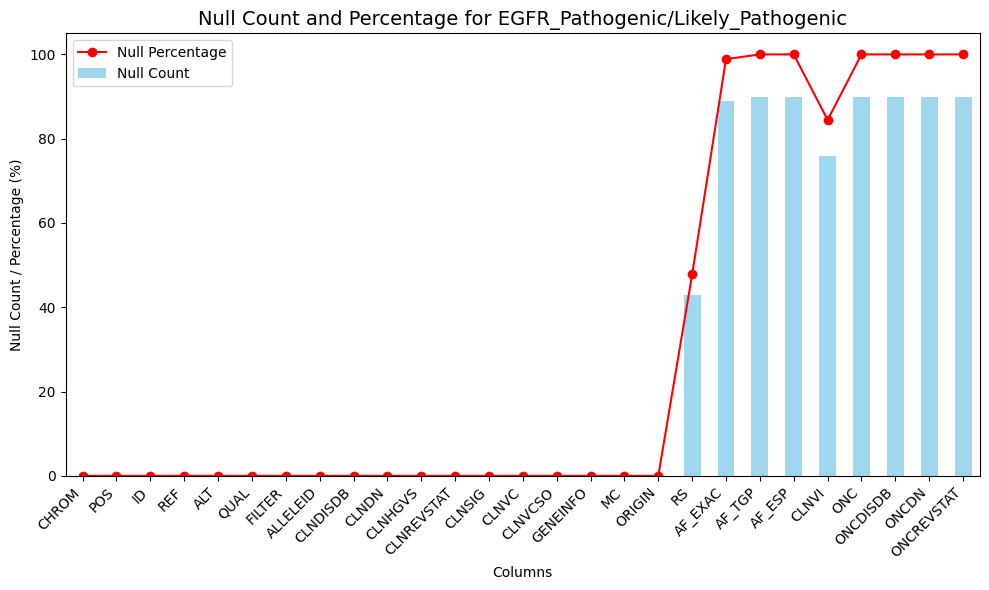

============== EGFR_Benign/Likely_Benign Summary ==============

Total rows: 1290
Total columns: 27



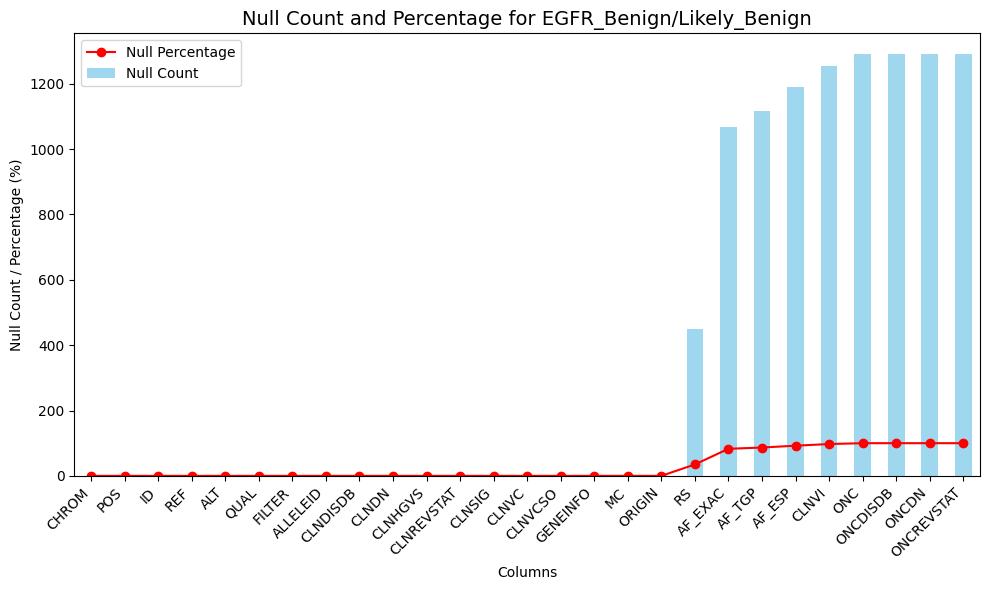

============== EGFR_VUS Summary ==============

Total rows: 1410
Total columns: 27



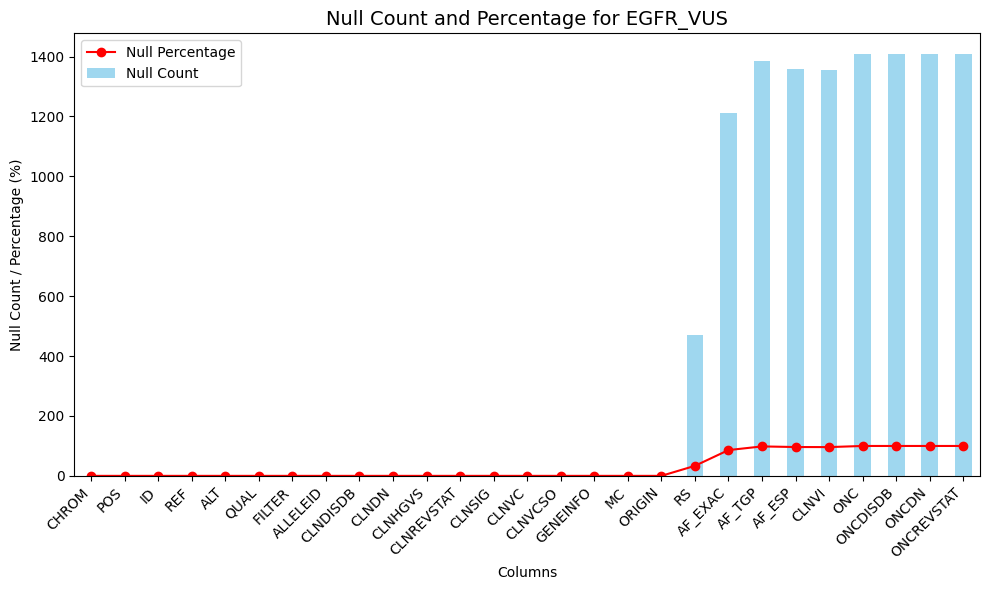

============== KRAS_Pathogenic/Likely_Pathogenic Summary ==============

Total rows: 58
Total columns: 27



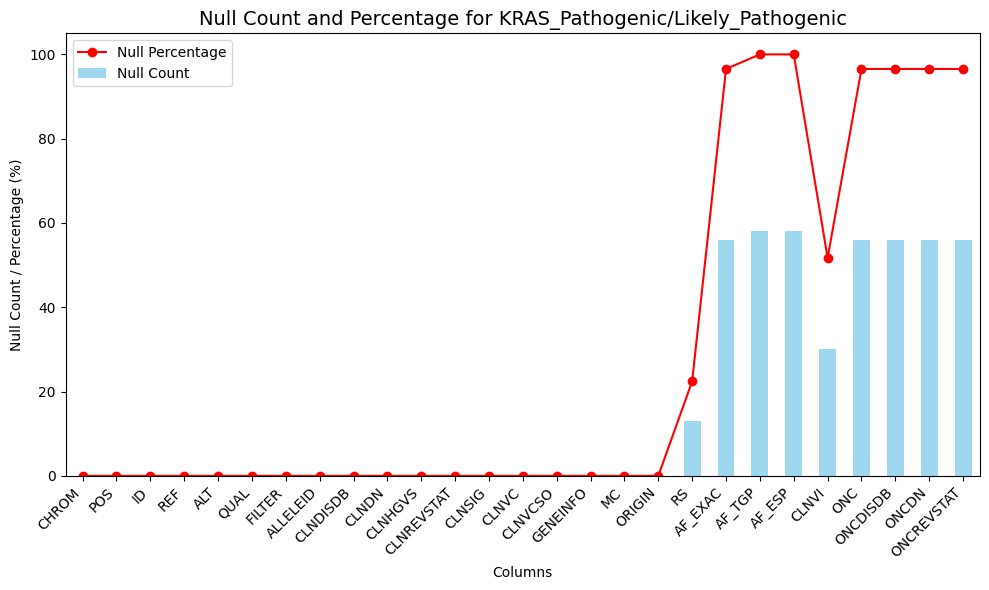

============== KRAS_Benign/Likely_Benign Summary ==============

Total rows: 146
Total columns: 27



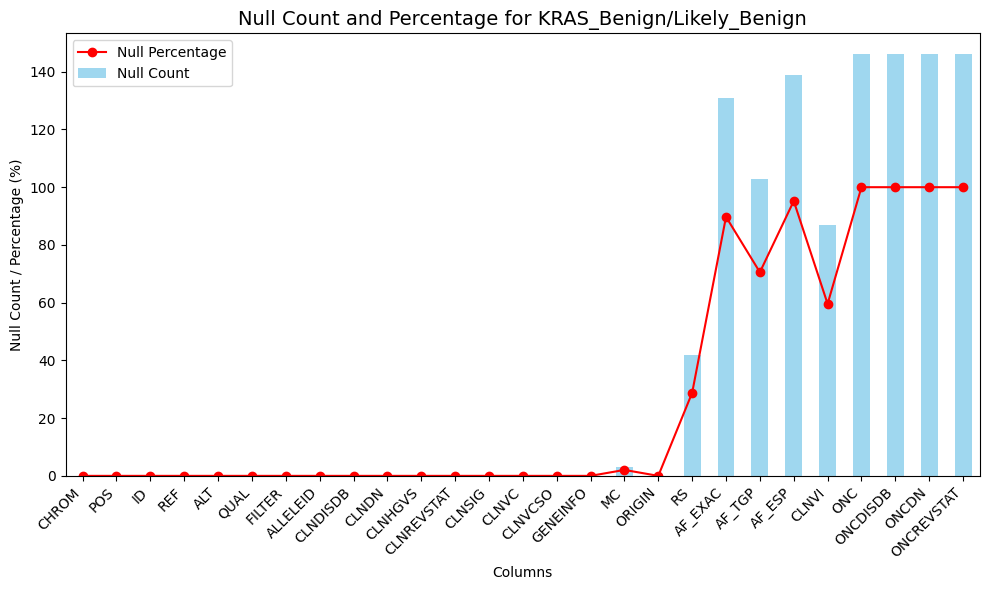

============== KRAS_VUS Summary ==============

Total rows: 198
Total columns: 27



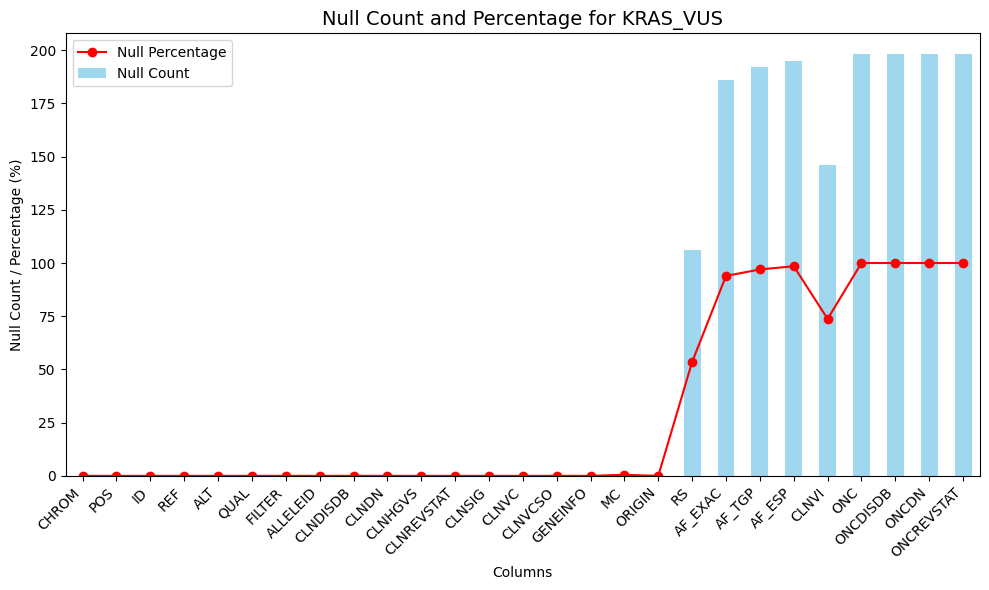

============== ALK_Pathogenic/Likely_Pathogenic Summary ==============

Total rows: 125
Total columns: 27



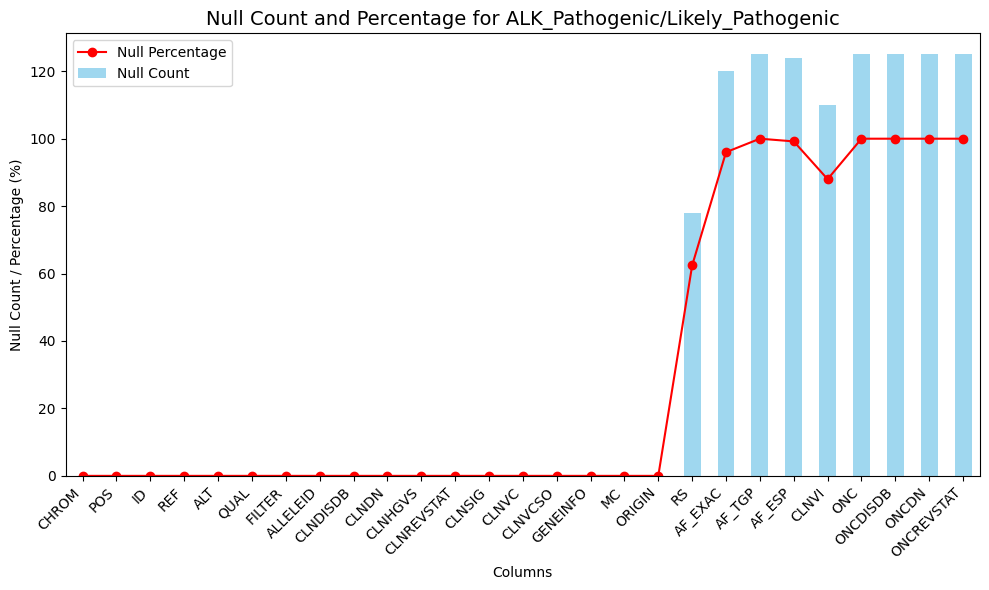

============== ALK_Benign/Likely_Benign Summary ==============

Total rows: 2460
Total columns: 27



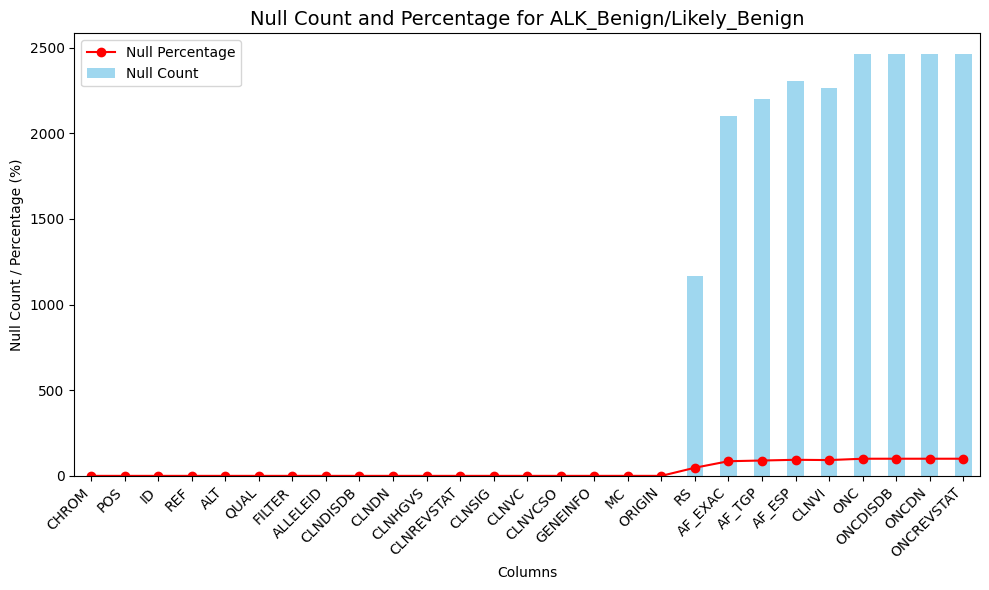

============== ALK_VUS Summary ==============

Total rows: 3433
Total columns: 27



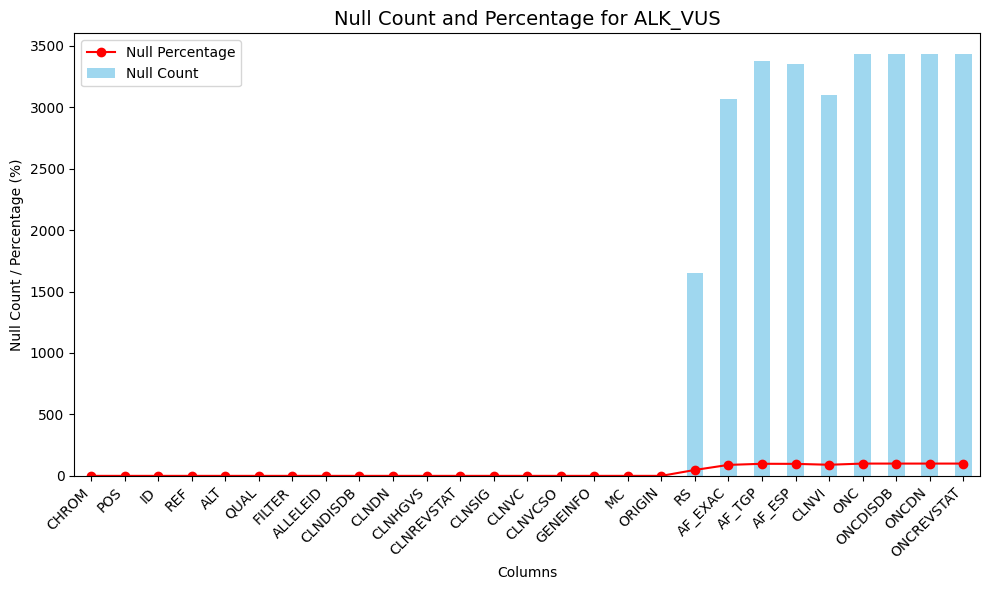

In [ ]:
import matplotlib.pyplot as plt

# Access and analyze the DataFrames using the dictionary
for df_name, df in filtered_dfs.items():
    # Check if DataFrame is empty
    if df.empty:
        print(f"-------------- {df_name} is Empty ------------------\n")
        continue

    print(f"============== {df_name} Summary ==============\n")

    # General Information
    print(f"Total rows: {len(df)}")
    print(f"Total columns: {len(df.columns)}\n")

    # Null Count and Percentage Visualization
    null_counts = df.isnull().sum()
    null_percentages = (null_counts / len(df)) * 100

    # Bar plot for null counts and percentages
    plt.figure(figsize=(10, 6))
    null_counts.plot(kind='bar', color='skyblue', alpha=0.8, label='Null Count')
    (null_percentages).plot(kind='line', color='red', marker='o', label='Null Percentage')
    plt.title(f"Null Count and Percentage for {df_name}", fontsize=14)
    plt.ylabel("Null Count / Percentage (%)")
    plt.xlabel("Columns")
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("=" * 50)  # Separator for clarity


identifying null columns, analyzing their significance and dropping the non relevant columns found

In [ ]:
for df_name, df in filtered_dfs.items():
    print(f"Number of columns with 0 non-nulls in {df_name}:")
    print(len(df.columns))

Number of columns with 0 non-nulls in EGFR_Pathogenic/Likely_Pathogenic:
27
Number of columns with 0 non-nulls in EGFR_Benign/Likely_Benign:
27
Number of columns with 0 non-nulls in EGFR_VUS:
27
Number of columns with 0 non-nulls in KRAS_Pathogenic/Likely_Pathogenic:
27
Number of columns with 0 non-nulls in KRAS_Benign/Likely_Benign:
27
Number of columns with 0 non-nulls in KRAS_VUS:
27
Number of columns with 0 non-nulls in ALK_Pathogenic/Likely_Pathogenic:
27
Number of columns with 0 non-nulls in ALK_Benign/Likely_Benign:
27
Number of columns with 0 non-nulls in ALK_VUS:
27


In [ ]:
# Iterate through the dictionary and drop columns with 0 non-null values
for df_name, df in filtered_dfs.items():
    # Drop columns with all NaN values
    filtered_dfs[df_name] = df.dropna(axis=1, how='all')

# Verify the changes
for df_name, df in filtered_dfs.items():
    print(f"After dropping empty columns, {df_name} has {len(df.columns)} columns.")


After dropping empty columns, EGFR_Pathogenic/Likely_Pathogenic has 21 columns.
After dropping empty columns, EGFR_Benign/Likely_Benign has 23 columns.
After dropping empty columns, EGFR_VUS has 27 columns.
After dropping empty columns, KRAS_Pathogenic/Likely_Pathogenic has 25 columns.
After dropping empty columns, KRAS_Benign/Likely_Benign has 23 columns.
After dropping empty columns, KRAS_VUS has 23 columns.
After dropping empty columns, ALK_Pathogenic/Likely_Pathogenic has 22 columns.
After dropping empty columns, ALK_Benign/Likely_Benign has 23 columns.
After dropping empty columns, ALK_VUS has 27 columns.


In [ ]:
for df_name, df in filtered_dfs.items():
  print(f"{df_name}: {df.isnull().sum()}")

EGFR_Pathogenic/Likely_Pathogenic: CHROM          0
POS            0
ID             0
REF            0
ALT            0
QUAL           0
FILTER         0
ALLELEID       0
CLNDISDB       0
CLNDN          0
CLNHGVS        0
CLNREVSTAT     0
CLNSIG         0
CLNVC          0
CLNVCSO        0
GENEINFO       0
MC             0
ORIGIN         0
RS            43
AF_EXAC       89
CLNVI         76
dtype: int64
EGFR_Benign/Likely_Benign: CHROM            0
POS              0
ID               0
REF              0
ALT              0
QUAL             0
FILTER           0
ALLELEID         0
CLNDISDB         0
CLNDN            0
CLNHGVS          0
CLNREVSTAT       0
CLNSIG           0
CLNVC            0
CLNVCSO          0
GENEINFO         0
MC               1
ORIGIN           0
RS             451
AF_EXAC       1069
AF_TGP        1118
AF_ESP        1191
CLNVI         1256
dtype: int64
EGFR_VUS: CHROM            0
POS              0
ID               0
REF              0
ALT              0
QUAL         

Get all unique columns:

In [ ]:
all_columns = set().union(*[set(df.columns) for df in filtered_dfs.values()])
print(all_columns)

{'AF_ESP', 'ONC', 'QUAL', 'CLNVCSO', 'CHROM', 'MC', 'CLNDN', 'CLNVI', 'ID', 'ORIGIN', 'ONCREVSTAT', 'CLNDISDB', 'GENEINFO', 'ALLELEID', 'REF', 'FILTER', 'CLNHGVS', 'CLNSIG', 'ALT', 'CLNREVSTAT', 'AF_EXAC', 'ONCDN', 'ONCDISDB', 'CLNVC', 'POS', 'AF_TGP', 'RS'}


Drop columns if more than 90% of their values are null in any single DataFrame or across all DataFrames.

In [ ]:
# Define a null threshold (e.g., 90%)
null_threshold = 0.9

for df_name, df in filtered_dfs.items():
    # Calculate the percentage of null values in each column
    null_percentage = df.isnull().mean()
    # Identify columns exceeding the threshold
    cols_to_drop = null_percentage[null_percentage > null_threshold].index
    # Drop sparse columns
    filtered_dfs[df_name] = df.drop(columns=cols_to_drop)
    print(f"{df_name}: Dropped columns with more then {null_threshold * 100}% nulls: {cols_to_drop.tolist()}")


EGFR_Pathogenic/Likely_Pathogenic: Dropped columns with more then 90.0% nulls: ['AF_EXAC']
EGFR_Benign/Likely_Benign: Dropped columns with more then 90.0% nulls: ['AF_ESP', 'CLNVI']
EGFR_VUS: Dropped columns with more then 90.0% nulls: ['AF_TGP', 'AF_ESP', 'CLNVI', 'ONC', 'ONCDISDB', 'ONCDN', 'ONCREVSTAT']
KRAS_Pathogenic/Likely_Pathogenic: Dropped columns with more then 90.0% nulls: ['AF_EXAC', 'ONC', 'ONCDISDB', 'ONCDN', 'ONCREVSTAT']
KRAS_Benign/Likely_Benign: Dropped columns with more then 90.0% nulls: ['AF_ESP']
KRAS_VUS: Dropped columns with more then 90.0% nulls: ['AF_EXAC', 'AF_TGP', 'AF_ESP']
ALK_Pathogenic/Likely_Pathogenic: Dropped columns with more then 90.0% nulls: ['AF_EXAC', 'AF_ESP']
ALK_Benign/Likely_Benign: Dropped columns with more then 90.0% nulls: ['AF_ESP', 'CLNVI']
ALK_VUS: Dropped columns with more then 90.0% nulls: ['AF_TGP', 'AF_ESP', 'CLNVI', 'ONC', 'ONCDISDB', 'ONCDN', 'ONCREVSTAT']


Retain Columns with Sufficient Data Across All DataFrames

In [ ]:
# Identify columns present in all DataFrames after dropping sparse columns
common_columns = set.intersection(*[set(df.columns) for df in filtered_dfs.values()])

# Retain only common columns
for df_name, df in filtered_dfs.items():
    filtered_dfs[df_name] = df[list(common_columns)]
    print(f"{df_name}: Retained common columns: {list(common_columns)}")

EGFR_Pathogenic/Likely_Pathogenic: Retained common columns: ['ORIGIN', 'REF', 'CLNDISDB', 'ALLELEID', 'MC', 'CLNVCSO', 'CHROM', 'ALT', 'QUAL', 'CLNREVSTAT', 'RS', 'FILTER', 'CLNHGVS', 'CLNDN', 'CLNSIG', 'ID', 'POS', 'CLNVC', 'GENEINFO']
EGFR_Benign/Likely_Benign: Retained common columns: ['ORIGIN', 'REF', 'CLNDISDB', 'ALLELEID', 'MC', 'CLNVCSO', 'CHROM', 'ALT', 'QUAL', 'CLNREVSTAT', 'RS', 'FILTER', 'CLNHGVS', 'CLNDN', 'CLNSIG', 'ID', 'POS', 'CLNVC', 'GENEINFO']
EGFR_VUS: Retained common columns: ['ORIGIN', 'REF', 'CLNDISDB', 'ALLELEID', 'MC', 'CLNVCSO', 'CHROM', 'ALT', 'QUAL', 'CLNREVSTAT', 'RS', 'FILTER', 'CLNHGVS', 'CLNDN', 'CLNSIG', 'ID', 'POS', 'CLNVC', 'GENEINFO']
KRAS_Pathogenic/Likely_Pathogenic: Retained common columns: ['ORIGIN', 'REF', 'CLNDISDB', 'ALLELEID', 'MC', 'CLNVCSO', 'CHROM', 'ALT', 'QUAL', 'CLNREVSTAT', 'RS', 'FILTER', 'CLNHGVS', 'CLNDN', 'CLNSIG', 'ID', 'POS', 'CLNVC', 'GENEINFO']
KRAS_Benign/Likely_Benign: Retained common columns: ['ORIGIN', 'REF', 'CLNDISDB', 'AL

In [ ]:
for df_name, df in filtered_dfs.items():
    print(f"{df_name}: Number of columns = {df.shape[1]}")

EGFR_Pathogenic/Likely_Pathogenic: Number of columns = 20
EGFR_Benign/Likely_Benign: Number of columns = 21
EGFR_VUS: Number of columns = 20
KRAS_Pathogenic/Likely_Pathogenic: Number of columns = 20
KRAS_Benign/Likely_Benign: Number of columns = 22
KRAS_VUS: Number of columns = 20
ALK_Pathogenic/Likely_Pathogenic: Number of columns = 20
ALK_Benign/Likely_Benign: Number of columns = 21
ALK_VUS: Number of columns = 20


Identify Columns with Inconsistent Dtypes

In [ ]:
from collections import defaultdict

# Dictionary to collect dtypes for each column across DataFrames
column_dtypes = defaultdict(dict)

# Gather dtypes for each column in each DataFrame
for df_name, df in filtered_dfs.items():
    for col in df.columns:
        column_dtypes[col][df_name] = df[col].dtype

# Print inconsistent dtypes
print("\n---- Column Dtype Analysis ----")
for col, dtypes in column_dtypes.items():
    if len(set(dtypes.values())) > 1:  # Check if dtypes differ
        print(f"Column '{col}' has inconsistent dtypes: {dtypes}")



---- Column Dtype Analysis ----


Impute Remaining Null Values:

Numerical columns: Replace null values with the median or mean.
Categorical columns: Replace null values with the mode or a placeholder.

In [ ]:
for df_name, df in filtered_dfs.items():
    print(f"\n---- Null Value Imputation for {df_name} ----")
    for col in df.columns:
        if df[col].isnull().sum() > 0:  # Check for null values
            if df[col].dtype in ['float64', 'int64']:  # Numerical columns
                imputation_value = df[col].median()  # Replace with median
                df[col].fillna(imputation_value, inplace=True)
                print(f"Replaced nulls in numerical column '{col}' with median: {imputation_value}")
            else:  # Categorical columns
                imputation_value = df[col].mode()[0] if not df[col].mode().empty else "Unknown"
                df[col].fillna(imputation_value, inplace=True)
                print(f"Replaced nulls in categorical column '{col}' with mode: {imputation_value}")



---- Null Value Imputation for EGFR_Pathogenic/Likely_Pathogenic ----
Replaced nulls in categorical column 'RS' with mode: 1034084415
Replaced nulls in categorical column 'CLNVI' with mode: ClinGen:CA10586342

---- Null Value Imputation for EGFR_Benign/Likely_Benign ----
Replaced nulls in categorical column 'MC' with mode: SO:0001627|intron_variant
Replaced nulls in categorical column 'RS' with mode: 1140475
Replaced nulls in categorical column 'AF_EXAC' with mode: 0.00001
Replaced nulls in categorical column 'AF_TGP' with mode: 0.00020

---- Null Value Imputation for EGFR_VUS ----
Replaced nulls in categorical column 'RS' with mode: 1028735720
Replaced nulls in categorical column 'AF_EXAC' with mode: 0.00001

---- Null Value Imputation for KRAS_Pathogenic/Likely_Pathogenic ----
Replaced nulls in categorical column 'RS' with mode: 121913236
Replaced nulls in categorical column 'CLNVI' with mode: ClinGen:CA10576919

---- Null Value Imputation for KRAS_Benign/Likely_Benign ----
Replaced

<ipython-input-22-adcf919c223d>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(imputation_value, inplace=True)


Data Integrity Validation

In [ ]:
print("\n----- Data Integrity Check -----\n")

# Check for duplicates and null counts
for df_name, df in filtered_dfs.items():
    duplicate_count = df.duplicated().sum()
    null_count = df.isnull().sum().sum()
    print(f"{df_name}: {duplicate_count} duplicates, {null_count} total null values.")

# Verify column consistency
columns_list = [df.columns for df in filtered_dfs.values()]
if all(columns.equals(columns_list[0]) for columns in columns_list):
    print("\nAll DataFrames have consistent column structures.")
else:
    print("\nWarning: Inconsistent column structures detected.")



----- Data Integrity Check -----

EGFR_Pathogenic/Likely_Pathogenic: 0 duplicates, 0 total null values.
EGFR_Benign/Likely_Benign: 0 duplicates, 0 total null values.
EGFR_VUS: 0 duplicates, 0 total null values.
KRAS_Pathogenic/Likely_Pathogenic: 0 duplicates, 0 total null values.
KRAS_Benign/Likely_Benign: 0 duplicates, 0 total null values.
KRAS_VUS: 0 duplicates, 0 total null values.
ALK_Pathogenic/Likely_Pathogenic: 0 duplicates, 0 total null values.
ALK_Benign/Likely_Benign: 0 duplicates, 0 total null values.
ALK_VUS: 0 duplicates, 0 total null values.



verify null values:

In [ ]:
for df_name, df in filtered_dfs.items():
  print(f"{df_name}:")
  if(df.isnull().sum().sum() == 0):
    print("No null values")
  else:
    print(df.isnull().sum())

EGFR_Pathogenic/Likely_Pathogenic:
No null values
EGFR_Benign/Likely_Benign:
No null values
EGFR_VUS:
No null values
KRAS_Pathogenic/Likely_Pathogenic:
No null values
KRAS_Benign/Likely_Benign:
No null values
KRAS_VUS:
No null values
ALK_Pathogenic/Likely_Pathogenic:
No null values
ALK_Benign/Likely_Benign:
No null values
ALK_VUS:
No null values


Detect and Handle Anomalies

Identify Negative Values (Anomalies):

In [ ]:
for df_name, df in filtered_dfs.items():
    numeric_cols = df.select_dtypes(include='number').columns
    for col in numeric_cols:
        invalid_values = (df[col] < 0).sum()
        if invalid_values > 0:
            print(f"\n---- Anomaly Check for {df_name} ----")
            print(f"Column '{col}' has {invalid_values} negative values. Replacing them.")
            median_value = df[col][df[col] >= 0].median()
            df[col] = df[col].apply(lambda x: median_value if x < 0 else x)

Detect and Handle Outliers (IQR Method)

In [ ]:
for df_name, df in filtered_dfs.items():
    numeric_cols = df.select_dtypes(include='number').columns
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        if not outliers.empty:
            print(f"\n---- Outlier Detection for {df_name} ----")
            print(f"Column '{col}' has {len(outliers)} outliers. Handling them.")
            df[col] = df[col].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))


Validate Column Consistency

In [ ]:
columns_list = [df.columns for df in filtered_dfs.values()]
if all(columns.equals(columns_list[0]) for columns in columns_list):
    print("\nAll DataFrames now have consistent column structures and dtypes.")
else:
    print("\nWarning: Column inconsistency persists. Investigate further.")



All DataFrames now have consistent column structures and dtypes.


Examine the POS column:

Visualization for Numerical Data:

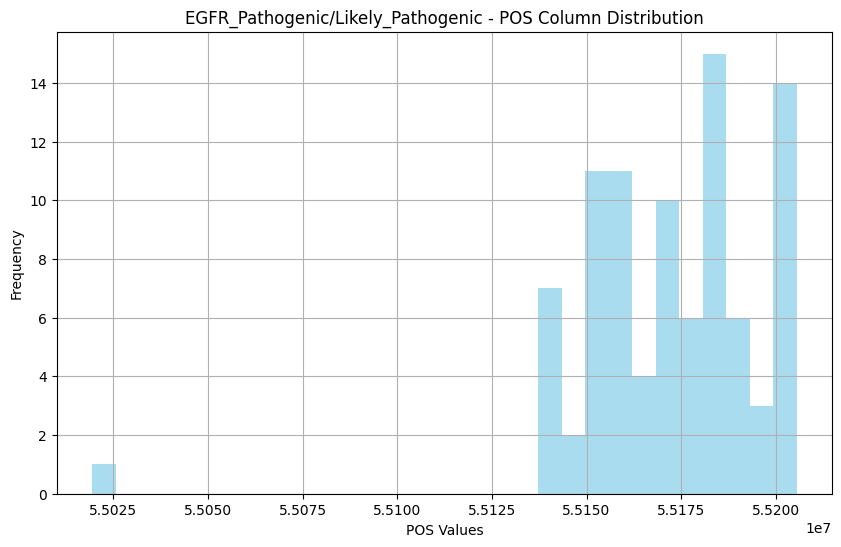

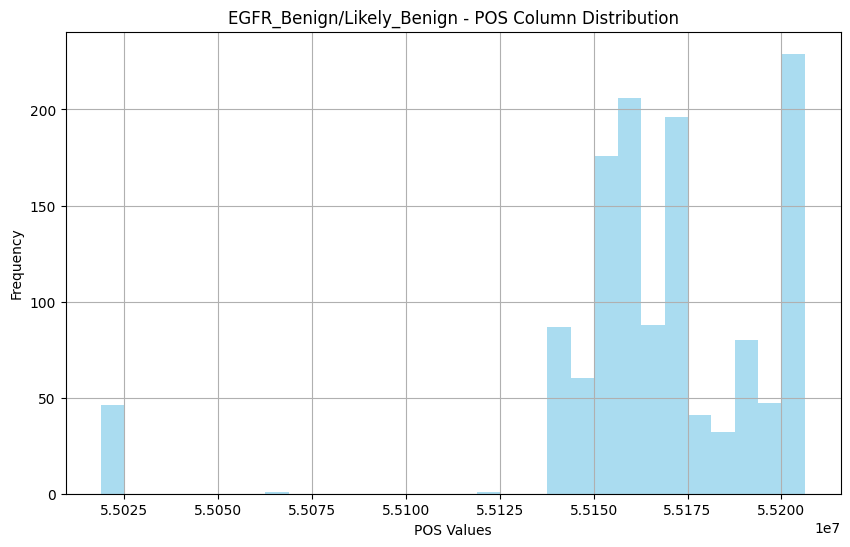

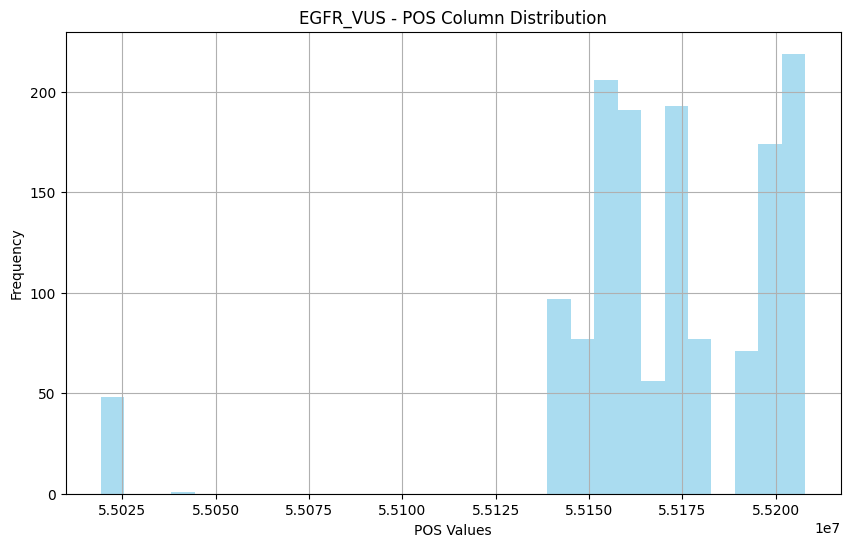

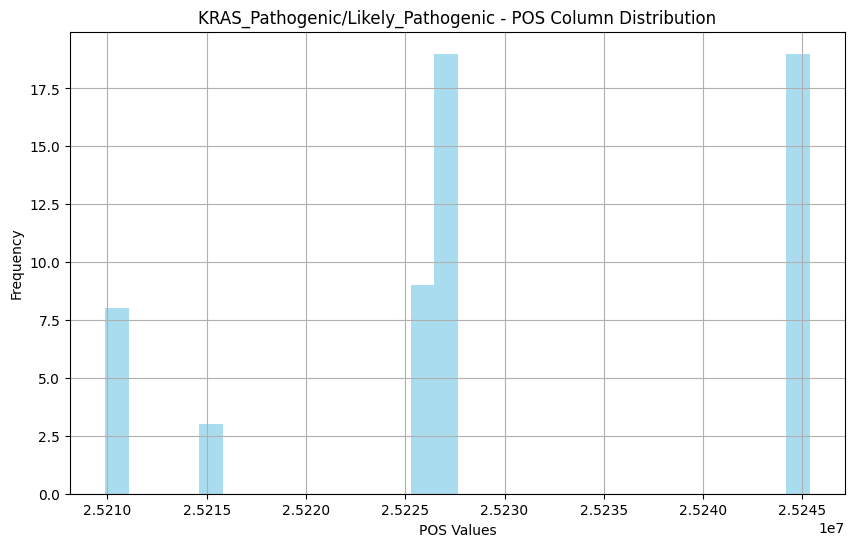

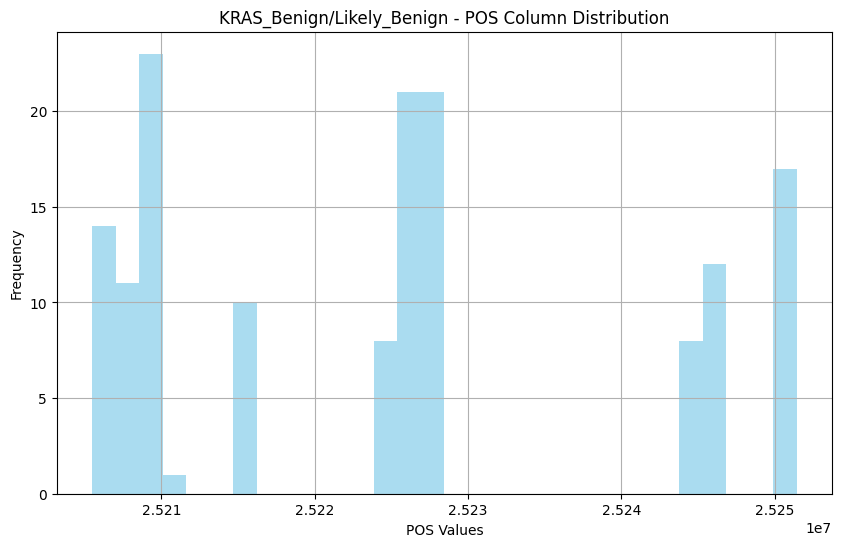

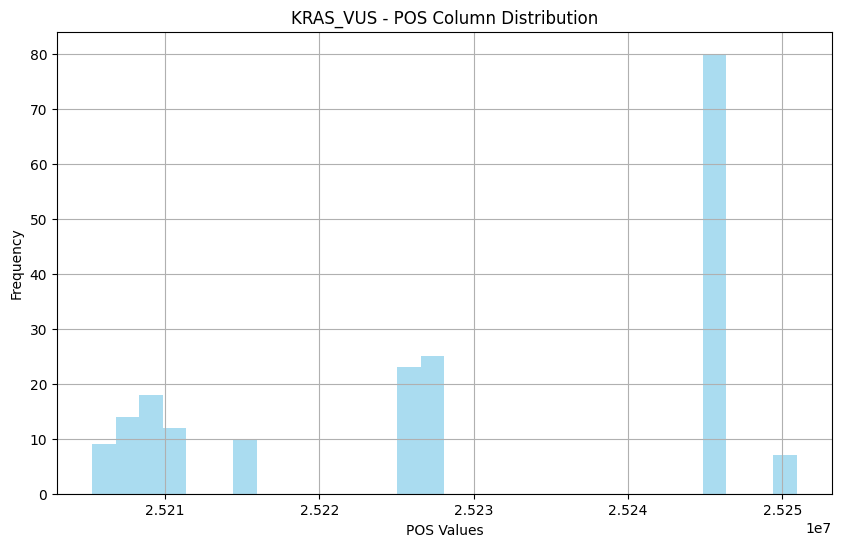

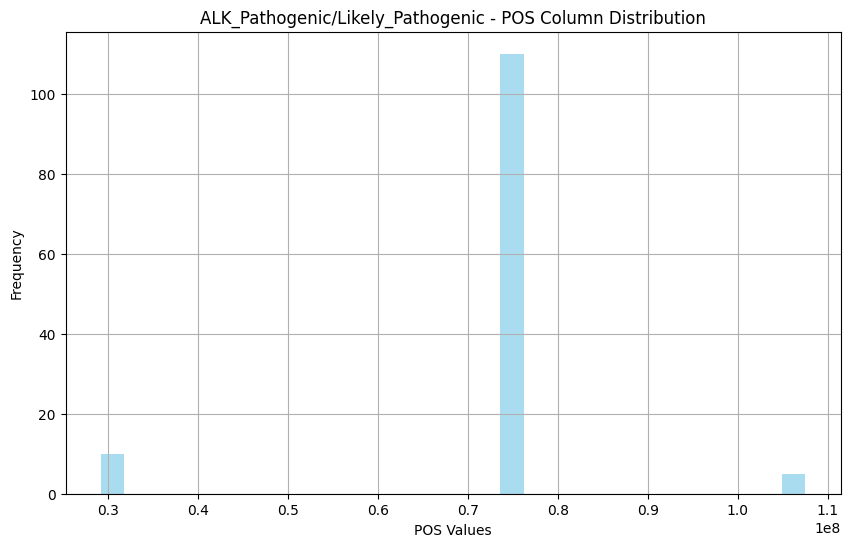

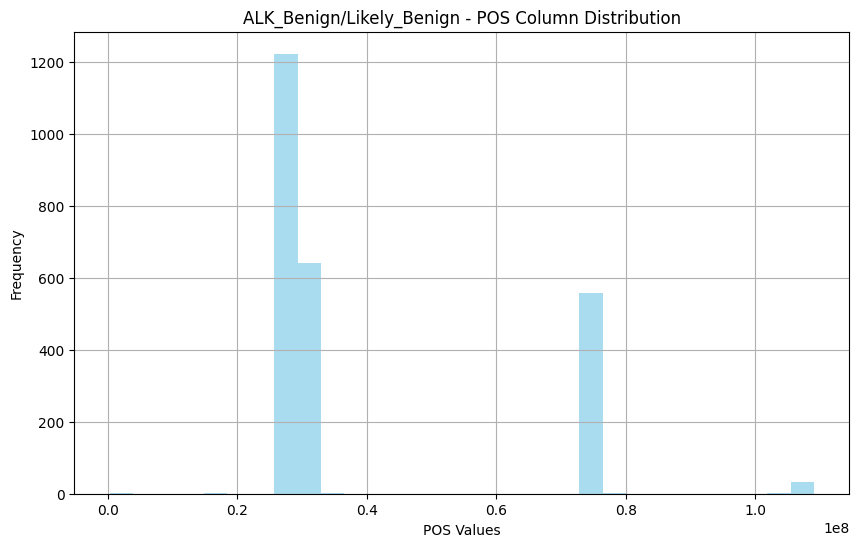

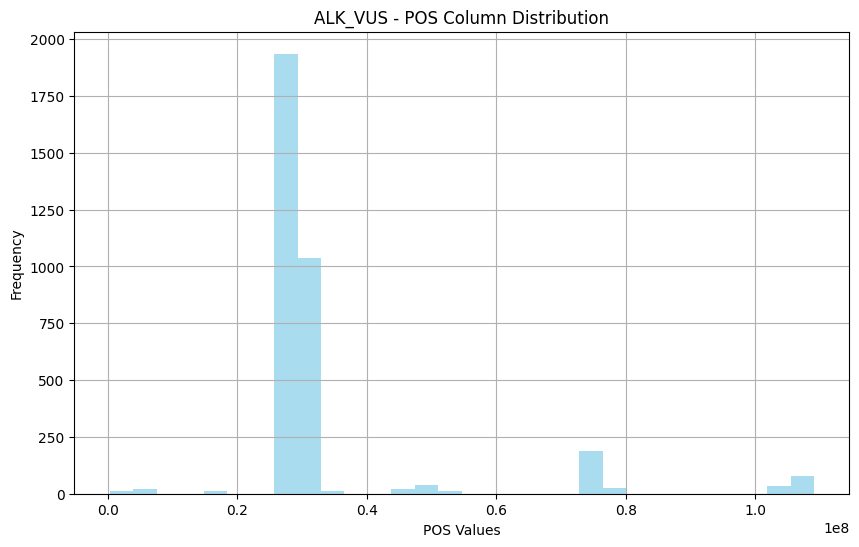

In [ ]:
import matplotlib.pyplot as plt

for df_name, df in filtered_dfs.items():
    if 'POS' in df.columns and pd.api.types.is_numeric_dtype(df['POS']):
        plt.figure(figsize=(10, 6))
        df['POS'].hist(bins=30, color='skyblue', alpha=0.7)
        plt.title(f"{df_name} - POS Column Distribution")
        plt.xlabel("POS Values")
        plt.ylabel("Frequency")
        plt.show()


# **Feature selection:**

assure the target value

In [ ]:
for df_name, df in filtered_dfs.items():
  print(df['CLNSIG'])

1149417    Likely_pathogenic
1149458           Pathogenic
1149470           Pathogenic
1149482           Pathogenic
1149504           Pathogenic
                 ...        
1151939    Likely_pathogenic
1151960           Pathogenic
1151972    Likely_pathogenic
1151973    Likely_pathogenic
1152245    Likely_pathogenic
Name: CLNSIG, Length: 90, dtype: object
1149337    Likely_benign
1149340    Likely_benign
1149345    Likely_benign
1149349    Likely_benign
1149353    Likely_benign
               ...      
1152288    Likely_benign
1152289    Likely_benign
1152290           Benign
1152291    Likely_benign
1152292           Benign
Name: CLNSIG, Length: 1290, dtype: object
1149341    Uncertain_significance
1149342    Uncertain_significance
1149343    Uncertain_significance
1149344    Uncertain_significance
1149346    Uncertain_significance
                    ...          
1152279    Uncertain_significance
1152281    Uncertain_significance
1152283    Uncertain_significance
1152284    Uncerta

1. Compute the correlation matrix for each DataFrame in filtered_dfs.
2. Extract and sort correlations between CLNSIG and other features.
3. Identify features with high absolute correlation values (e.g.,correlation| > 0.2).

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

for key, df in filtered_dfs.items():
    print(f"Analyzing {key}...")

    # Compute correlation matrix
    correlation_matrix = df.corr()

    # Extract correlation with CLNSIG
    target_correlation = correlation_matrix['CLNSIG'].sort_values(ascending=False)
    print(f"Correlations with CLNSIG for {key}:\n{target_correlation}\n")

    # Visualize the correlations
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title(f"Correlation Matrix for {key}")
    plt.show()

    # Filter features with |correlation| > 0.2
    significant_features = target_correlation[abs(target_correlation) > 0.2].index.tolist()
    significant_features.remove('CLNSIG')  # Exclude target itself
    print(f"Significant features for {key} (|correlation| > 0.2): {significant_features}\n")


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Example dataset (replace with your actual data)
data = {
    "CLNVC": ["Deletion", "SNV", "Deletion", "SNV", "Deletion"],
    "CLNSIG": ["Pathogenic", "Benign", "Likely Benign", "Pathogenic", "VUS"],
    "POS": [66927, 69134, 67000, 69000, 67500],
    "MC": ["Missense Variant", "Intron Variant", "Missense Variant", "Intron Variant", "Missense Variant"]
}

for df_name, df in filtered_dfs.items():
  df = pd.DataFrame(data)

  # Map categorical values to numbers
  df["CLNVC_Num"] = df["CLNVC"].map({"Deletion": 1, "SNV": 2})
  df["CLNSIG_Num"] = df["CLNSIG"].map({"Pathogenic": 1, "Likely Benign": 0, "Benign": 0, "VUS": -1})
  df["MC_Num"] = df["MC"].map({"Missense Variant": 1, "Intron Variant": 0})


NameError: name 'filtered_dfs' is not defined

# Correlation between Variant Type (CLNVC) and Clinical Significance (CLNSIG)
Question:
Does the type of variant (e.g., Deletion or Single Nucleotide Variant) correlate with its clinical impact (e.g., Pathogenic or Benign)?

Action:
Map CLNVC to numerical values (e.g., Deletion = 1, Single Nucleotide Variant = 2).
Map CLNSIG to numerical values (e.g., Pathogenic = 1, Likely Benign = 0).
Visualization:
Create a bar chart to show the frequency of each variant type for each clinical significance category.


Visualization 1: CLNVC vs. CLNSIG

<ipython-input-33-ed3ab8d77782>:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="CLNVC", y="CLNSIG_Num", data=df, ci=None)


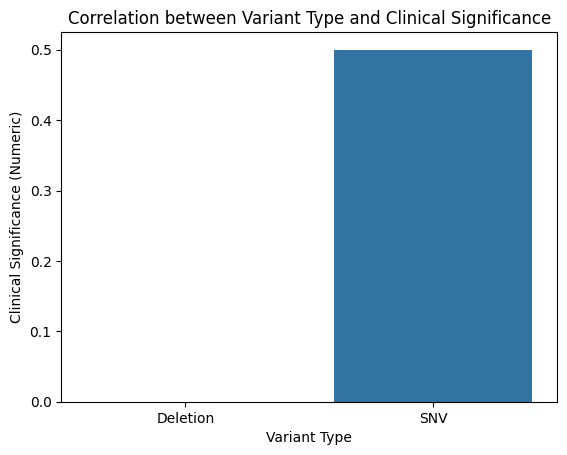

In [ ]:
sns.barplot(x="CLNVC", y="CLNSIG_Num", data=df, ci=None)
plt.title("Correlation between Variant Type and Clinical Significance")
plt.ylabel("Clinical Significance (Numeric)")
plt.xlabel("Variant Type")
plt.show()

# Correlation between Variant Position (POS) and Clinical Significance (CLNSIG)
Question:
Do variants located at certain positions in the genome tend to be more harmful?

Action:
Divide positions (POS) into ranges (e.g., genomic intervals).
Examine the frequency of clinical significance (CLNSIG) across these ranges.
Visualization:
Create a scatter plot where the X-axis represents POS and the Y-axis represents CLNSIG (mapped to numerical values).

Visualization 2: POS vs. CLNSIG

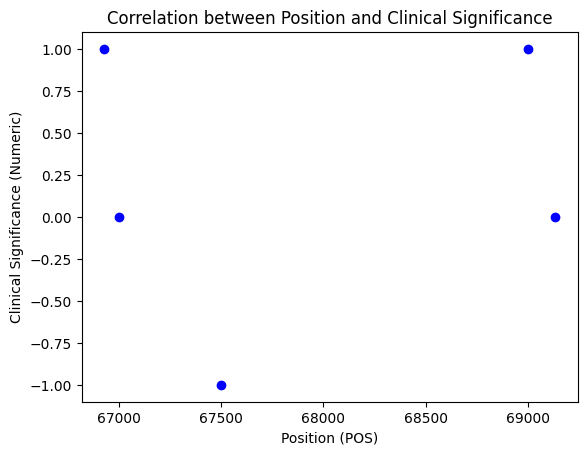

In [ ]:
plt.scatter(df["POS"], df["CLNSIG_Num"], c="blue")
plt.title("Correlation between Position and Clinical Significance")
plt.xlabel("Position (POS)")
plt.ylabel("Clinical Significance (Numeric)")
plt.show()


Visualization 3: MC vs. CLNSIG

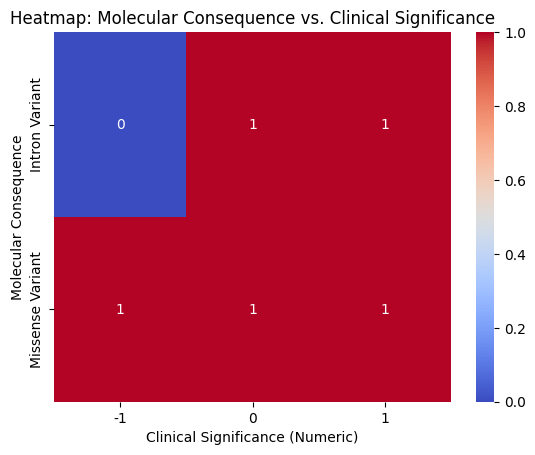

In [ ]:
sns.heatmap(pd.crosstab(df["MC"], df["CLNSIG_Num"]), annot=True, cmap="coolwarm", fmt="d")
plt.title("Heatmap: Molecular Consequence vs. Clinical Significance")
plt.ylabel("Molecular Consequence")
plt.xlabel("Clinical Significance (Numeric)")
plt.show()


# Train-Test Split Code

In [ ]:
from sklearn.model_selection import train_test_split

# Dictionary to store train-test splits
train_test_data = {}

# Iterate over each DataFrame in filtered_dfs
for key, df in filtered_dfs.items():
    print(f"Splitting data for {key}...")

    # Define features (X) and target (y)
    X = df.drop(columns=['CLNSIG'])  # Drop target column for features
    y = df['CLNSIG']                 # Target column

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y if y.nunique() > 1 else None
    )

    # Store the splits in a dictionary
    train_test_data[key] = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test
    }

    # Output summary
    print(f"{key}:")
    print(f"  Training set size: {X_train.shape[0]}")
    print(f"  Testing set size: {X_test.shape[0]}\n")